In [2]:
import pathlib
import tensorflow as tf
import os

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [5]:

# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [7]:
batch_size=32
image_height=180
image_width=180

In [8]:
ds_train=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(image_height,image_width),label_mode='categorical',seed=111,subset='training',validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
ds_test=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(image_height,image_width),label_mode='categorical',seed=111,subset='validation',validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
class_names=ds_train.class_names
print(class_names,'\n')

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 



## Visualization of data

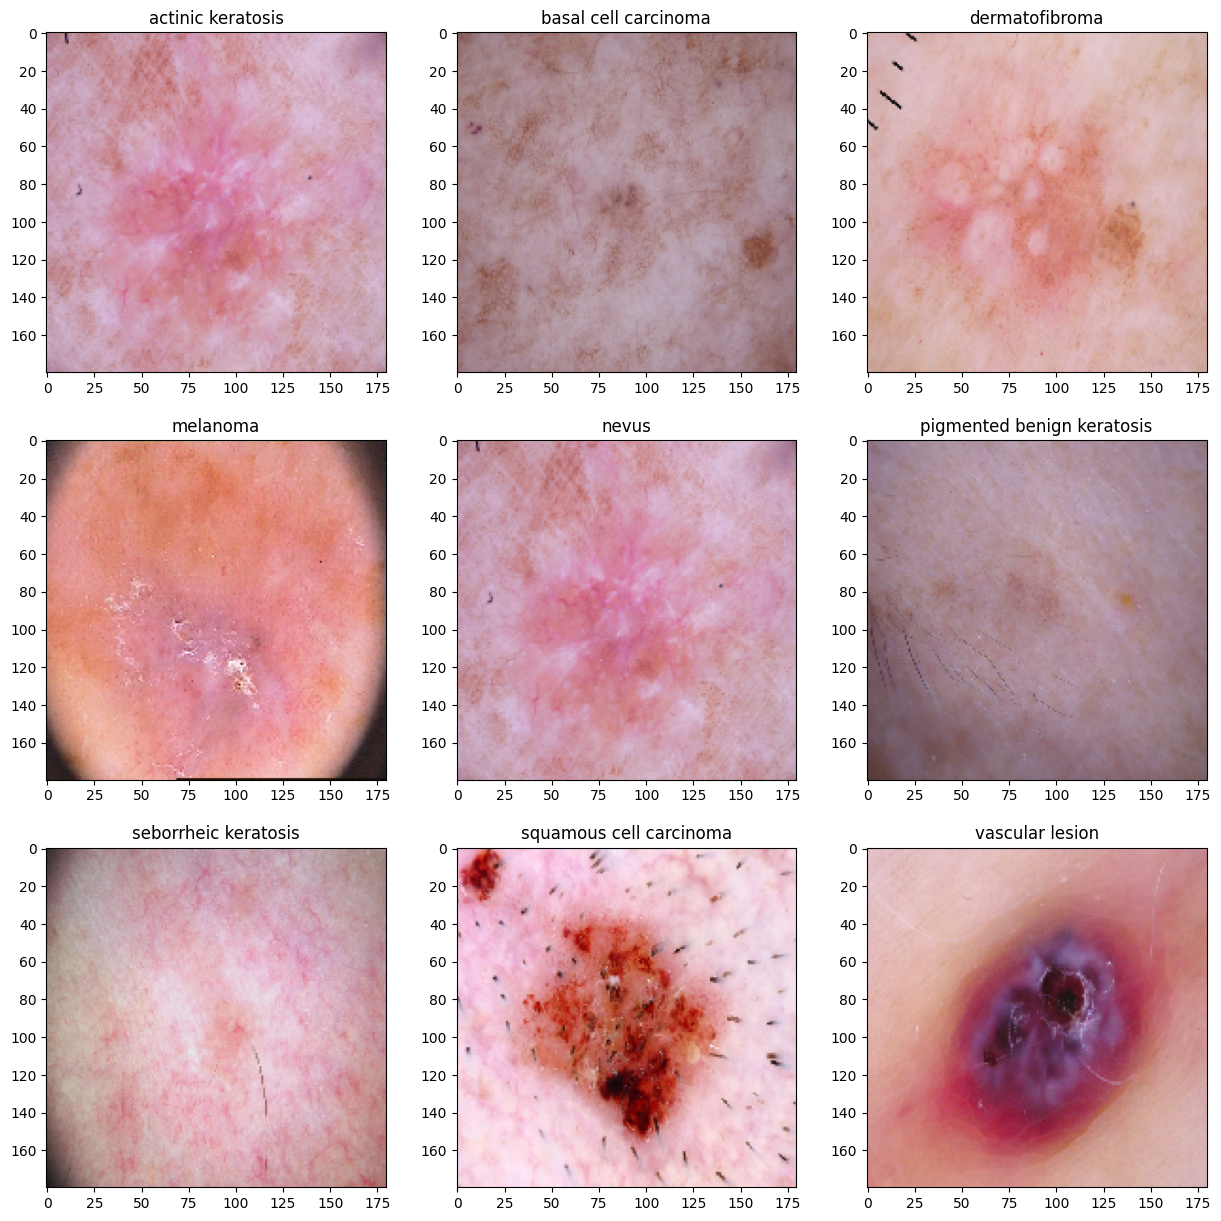

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

files_path_per_dir={}

for cls in class_names:
  files_path_per_dir[cls]=list(map(lambda x:str(data_dir_train)+'/'+cls+'/'+x,os.listdir(str(data_dir_train)+'/'+cls)))

plt.figure(figsize=(15,15))
i=0
for cls in class_names:
  path_list=files_path_per_dir[cls][:1]
  i+=1
  plt.subplot(3,3, i)
  plt.imshow(load_img(path_list[0],target_size=(image_height,image_width)))
  plt.title(cls)

In [12]:
autotune=tf.data.experimental.AUTOTUNE
ds_train=ds_train.cache().shuffle(1000).prefetch(buffer_size=autotune)
ds_test=ds_test.cache().prefetch(buffer_size=autotune)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [14]:
input_shape=(image_height, image_width,3)

model=Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))


In [15]:
model.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [17]:
test_summary=model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=20
)

Epoch 1/20
56/56 [==============================] - 201s 3s/step - loss: 2.0972 - accuracy: 0.2344 - val_loss: 1.9352 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 169s 3s/step - loss: 1.7830 - accuracy: 0.3516 - val_loss: 1.6441 - val_accuracy: 0.3915
Epoch 3/20
56/56 [==============================] - 170s 3s/step - loss: 1.5690 - accuracy: 0.4386 - val_loss: 1.5345 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 176s 3s/step - loss: 1.4899 - accuracy: 0.4799 - val_loss: 1.5291 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 170s 3s/step - loss: 1.4173 - accuracy: 0.5078 - val_loss: 1.4820 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 163s 3s/step - loss: 1.3080 - accuracy: 0.5307 - val_loss: 1.3649 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 161s 3s/step - loss: 1.2686 - accuracy: 0.5452 - val_loss: 1.4860 - val_accuracy: 0.4810
Epoch 8/20
56

In [ ]:
# Model seems to be overfitting as the valiation accuracy is decreasing gradually even though the accuracy is increasing

In [18]:
# The input dataset will be augemented to overcome the overfitting problem

rescaling=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255)]
)

augumented_data=tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")  ,

 layers.experimental.preprocessing.RandomRotation(0.1)  ,

 layers.experimental.preprocessing.RandomZoom(0.1)

])

In [22]:

model2=Sequential()

model2.add(augumented_data)
model.add(rescaling)


#1st Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer to randomly drop the input data to address the overfitting problem
model2.add(layers.Dropout(0.25))

#2nd Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer to randomly drop the input data to address the overfitting problem
model2.add(layers.Dropout(0.25))

#3rd Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(512,activation='relu'))

model2.add(layers.Dense(128, activation='relu'))

#Dropout layer to randomly drop the input data to address the overfitting problem
model2.add(layers.Dropout(0.50))

model2.add(layers.Dense(len(class_names),activation='softmax'))

In [23]:
model2.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [24]:
test_summary=model2.fit(
    ds_train,
    validation_data=ds_test,
    epochs=20
)

Epoch 1/20
56/56 [==============================] - 197s 3s/step - loss: 164.1543 - accuracy: 0.1484 - val_loss: 2.1612 - val_accuracy: 0.1991
Epoch 2/20
56/56 [==============================] - 186s 3s/step - loss: 2.0971 - accuracy: 0.2009 - val_loss: 2.0820 - val_accuracy: 0.1991
Epoch 3/20
56/56 [==============================] - 194s 3s/step - loss: 2.0515 - accuracy: 0.1931 - val_loss: 2.0187 - val_accuracy: 0.1991
Epoch 4/20
56/56 [==============================] - 187s 3s/step - loss: 2.0384 - accuracy: 0.1936 - val_loss: 2.0172 - val_accuracy: 0.1991
Epoch 5/20
56/56 [==============================] - 189s 3s/step - loss: 2.0302 - accuracy: 0.1970 - val_loss: 2.0154 - val_accuracy: 0.1991
Epoch 6/20
56/56 [==============================] - 191s 3s/step - loss: 2.0263 - accuracy: 0.2171 - val_loss: 2.0173 - val_accuracy: 0.1991
Epoch 7/20
56/56 [==============================] - 196s 4s/step - loss: 2.0257 - accuracy: 0.1908 - val_loss: 2.0174 - val_accuracy: 0.1991
Epoch 8/20
